In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
#load dataset
df = pd.read_csv("heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Regression
## 

In [47]:
#One-hot encoding
df["Sex_M"] = np.where(df["Sex"]=="M",1,0)

df["ChestPainType_TA"] = np.where(df["ChestPainType"]=="TA",1,0)
df["ChestPainType_ATA"] = np.where(df["ChestPainType"]=="ATA",1,0)
df["ChestPainType_NAP"] = np.where(df["ChestPainType"]=="NAP",1,0)

df["RestingECG_N"] = np.where(df["RestingECG"]=="Normal",1,0)
df["RestingECG_ST"] = np.where(df["RestingECG"]=="ST",1,0)

df["ExerciseAngina_Y"] = np.where(df["ExerciseAngina"]=="Y",1,0)

df["ST_Slope_U"] = np.where(df["ST_Slope"]=="Up",1,0)
df["ST_Slope_F"] = np.where(df["ST_Slope"]=="Flat",1,0)

#var = ["Age","RestingBP","HeartDisease","MaxHR","Oldpeak","Sex_M","FastingBS","ChestPainType_TA","ChestPainType_ATA","ChestPainType_NAP","RestingECG_N","RestingECG_ST","ExerciseAngina_Y","ST_Slope_U","ST_Slope_F","Cholesterol"]

var = ["Age","Sex_M","RestingBP","HeartDisease","MaxHR","Oldpeak","FastingBS","ChestPainType_TA","ChestPainType_ATA","ChestPainType_NAP","RestingECG_N","RestingECG_ST","ExerciseAngina_Y","ST_Slope_U","ST_Slope_F","Cholesterol"]
df2 = df[var]

# Remove cholesterol levels = 0
df2 = df2[df2["Cholesterol"]!=0]

In [48]:
#Standardization
##Standardise Function
def standardise(df, columns):
    new_df = df.copy(deep=True)
    for col in columns:
        new_df[col] = (df[col] - df[col].mean()) / df[col].std()
    return new_df

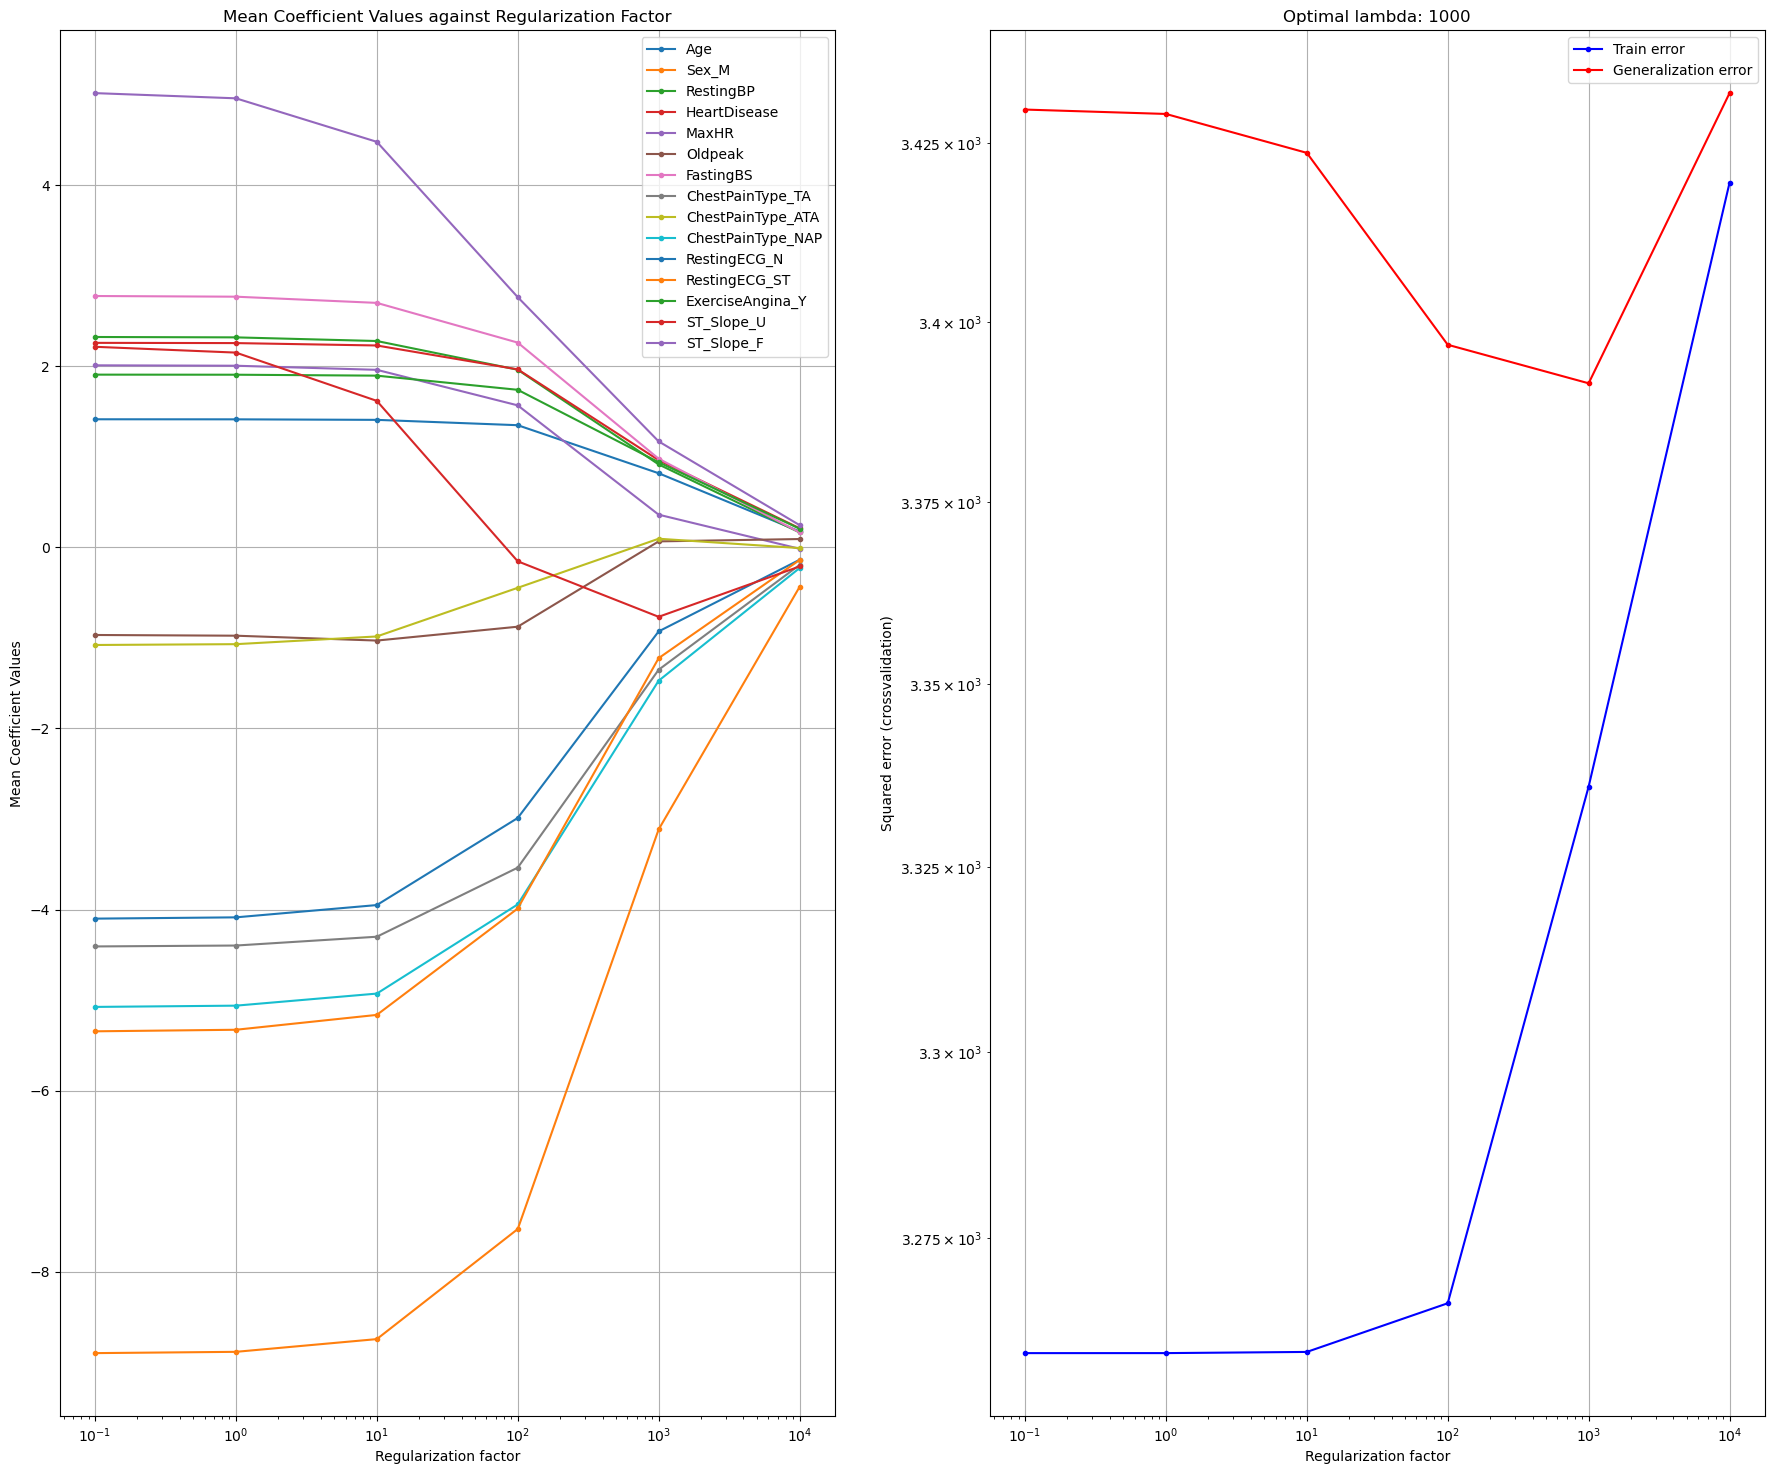

Regularized linear regression:
- Training error: 3353.516656293403
- Test error:     3456.505314999335
- R^2 train:     0.040252212980503965
- R^2 test:     0.004281879325423



In [51]:
from matplotlib.pylab import (figure, semilogx, loglog, xlabel, ylabel, legend, 
                           title, subplot, show, grid)
import numpy as np
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import model_selection
from toolbox_02450 import rlr_validate

X = df2[var[:-1]].to_numpy()
y = df2[var[-1]].to_numpy()
attributeNames = var[:-1]
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attributeNames = [u'Offset']+attributeNames
M = M+1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(K, shuffle=True)

# Values of lambda
lambdas = [0.1, 1, 10, 100, 1000, 10000] #np.power(10.,range(-1,6))

# Initialize variables
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
w_rlr = np.empty((M,K))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))

k=0
for train_index, test_index in CV.split(X,y):
    
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10    
    
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :] 
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :]
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]
    #m = lm.LinearRegression().fit(X_train, y_train)
    #Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    #Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]
    
    # Display the results for the last cross-validation fold
    if k == K-1:
        figure(k, figsize=(22,18))
        subplot(1,2,1)
        title('Mean Coefficient Values against Regularization Factor')
        semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
        xlabel('Regularization factor')
        ylabel('Mean Coefficient Values')
        grid()
        legend(attributeNames[1:], loc='best')
        
        subplot(1,2,2)
        title('Optimal lambda: {}'.format(opt_lambda))
        loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
        xlabel('Regularization factor')
        ylabel('Squared error (crossvalidation)')
        legend(['Train error','Generalization error'])
        grid()
    k+=1
show()
# Display results
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

In [8]:
df_coef = pd.DataFrame()

# Find the index of the lambda with the lowest generalization error
opt_lambda_index = np.argmin(test_err_vs_lambda)

# Get the optimal lambda
opt_lambda = lambdas[opt_lambda_index]

# Get the corresponding weights (coefficients)
optimal_weights = w_rlr[:, opt_lambda_index]

# Print the coefficient values
k = 1
df_coef["Feature Name"], df_coef["Coefficient Term"]  = attributeNames[1:], ['w'+str(i) for i in range(1,16)]
df_coef["Coefficient Value"] = optimal_weights[1:]
intercept = optimal_weights[0]
#for feature_name, coefficient in zip(attributeNames[1:], optimal_weights[1:]):
#    print(f'Feature: {feature_name}, Coefficient w{k}: {coefficient:.4f}')
#    k+=1
df_coef.loc[15] = ['Intercept (Bias)','w0', f'{intercept:.4f}']
# Print the intercept (bias) term
#print(f'Intercept (Bias) w0: {intercept:.4f}')
df_coef

,Feature Name,Coefficient Term,Coefficient Value
0,Age,w1,0.663555
1,Sex_M,w2,-3.097299
2,RestingBP,w3,1.44133
3,HeartDisease,w4,1.149737
4,MaxHR,w5,0.428705
5,Oldpeak,w6,0.791714
6,FastingBS,w7,1.25025
7,ChestPainType_TA,w8,-1.036468
8,ChestPainType_ATA,w9,-0.039327
9,ChestPainType_NAP,w10,-1.614038


In [42]:
# 2 layer cross validation
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from keras.optimizers import Adam, SGD, RMSprop

# Assuming X and y are your dataset features and target variable
# Define K1 and K2
K1 = 10
K2 = 10

# Define the range of values for h (number of hidden units)
h_values = [1, 10, 20, 30, 50]  # Add more values as needed

# Define the range of values for λ
lambda_values = [100, 250, 500, 750, 1000, 1250]  # Add more values as needed

kf1 = KFold(n_splits=K1, shuffle=True)
kf2 = KFold(n_splits=K2, shuffle=True)

df3 = standardise(df2, var[:-1])

X = df3[var[:-1]].to_numpy()
y = df3[var[-1]].to_numpy()

i = 1

for train_index, test_index in kf1.split(X):
    # Outer cross-validation loop
    X_train_outer, X_test_outer = X[train_index], X[test_index]
    y_train_outer, y_test_outer = y[train_index], y[test_index]

    best_model1 = None #ANN
    errors_model1 = {1:[], 10:[], 20:[], 30:[], 50:[]}
    best_model2 = None #LR
    errors_model2 = {100:[],250:[],500:[],750:[],1000:[],1250:[]}
    errors_model3 = {}
    
    for train_index_inner, val_index in kf2.split(X_train_outer):
        # Inner cross-validation loop
        X_train_inner, X_val = X_train_outer[train_index_inner], X_train_outer[val_index]
        y_train_inner, y_val = y_train_outer[train_index_inner], y_train_outer[val_index]
        
        #iterate through different models
        m_models = [0,1,2]
        
        for m in m_models:     
            if m == 0: #ANN
                for h in h_values:
                    # Create an ANN model
                    model = Sequential()
                    model.add(Dense(h, input_dim=X_train_inner.shape[1], activation='relu', use_bias=True))
                    model.add(Dense(1, activation='linear'))

                    # Compile the model
                    optimizer = SGD(learning_rate=0.001)
                    model.compile(loss='mean_squared_error', optimizer=optimizer)

                    # Train the model
                    #print(y_train_inner)
                    model.fit(X_train_inner, y_train_inner, verbose=0)
                    
                    # Evaluate the model on the validation set
                    val_predictions = model.predict(X_val, verbose=0)
                    #print("ANN pred: ", val_predictions)
                    #print("test data: ", y_val)
                    val_error = mean_squared_error(y_val, val_predictions)
                    #print(val_error)
                    
                    errors_model1[h].append(val_error)
                
            elif m == 1: #Linear Regression
                #determine best lambda for linear regression model
                for l in lambda_values:
                    model = Ridge(alpha=l, fit_intercept=True)
                    model.fit(X_train_inner, y_train_inner)
                    
                    val_predictions = model.predict(X_val)
                    #print("LR pred: ", val_predictions)
                    #print("test data: ", y_val)
                    val_error = mean_squared_error(y_val, val_predictions)
                    
                    errors_model2[l].append(val_error)
                
            else: #baseline model
                mean_y_train = np.mean(y_train_inner)
                model = LinearRegression()
                model.fit(X_train_inner, [mean_y_train] * len(X_train_inner))
                
                val_predictions = [mean_y_train] * len(y_val)
                #print("BL pred: ", val_predictions)
                #print("test data: ", y_val)
                val_error = mean_squared_error(y_val, val_predictions)
                
                errors_model3[mean_y_train] = val_error

            # Train the best model on the entire Dtrain_j
    
    print(f"i={i} Outer Fold:")
    # Use the best h value to create the ANN model and test on y_test_outer
    best_h = 0
    best_mean_error = float('inf')
    for h, errors in errors_model1.items():
        mean_error = np.mean(errors)
        if mean_error < best_mean_error:
            best_mean_error = mean_error
            best_h = h
    print("best h: ", best_h)
    
    model = Sequential()
    model.add(Dense(best_h, input_dim=X_train_outer.shape[1], activation='relu', use_bias=True))
    model.add(Dense(1, activation='linear'))
    optimizer = SGD(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(X_train_outer, y_train_outer, verbose=0)

    test_predictions = model.predict(X_test_outer, verbose=0)
    test_error = mean_squared_error(y_test_outer, test_predictions)
    print(f'Test Error ANN: {test_error}')
    
    # Use the best l value to create the LR model and test on y_test_outer
    best_l = 0
    best_mean_error = float('inf')
    for l, errors in errors_model2.items():
        mean_error = np.mean(errors)
        if mean_error < best_mean_error:
            best_mean_error = mean_error
            best_l = l
    print("best l: ", best_l)
    model = Ridge(alpha=best_l, fit_intercept=True)
    model.fit(X_train_outer, y_train_outer)
    test_predictions = model.predict(X_test_outer)
    test_error = mean_squared_error(y_test_outer, test_predictions)
    print(f'Test Error LR: {test_error}')
    
    #baseline model
    baseline_list = list(errors_model3.items())
    mean_y = sorted(baseline_list, key = lambda x: x[1])[0][0] #extract the mean y with the lowest error
    model = LinearRegression()
    model.fit(X_train_outer, [mean_y] * len(X_train_outer))
    test_predictions = [mean_y] * len(y_test_outer)
    #print("baseline model: ", test_predictions)
    #print("test data: ", y_test_outer)
    test_error = mean_squared_error(y_test_outer, test_predictions)
    print(f'Test Error Baseline: {test_error}')
    
    i+=1
    print("=====================================")

i=1 Outer Fold:
best h:  50
Test Error ANN: 1.196365325725019
best l:  100
Test Error LR: 0.11619752691350137
Test Error Baseline: 0.24970132888908386
i=2 Outer Fold:
best h:  30
Test Error ANN: 0.6836642301980616
best l:  100
Test Error LR: 0.14575551270706502
Test Error Baseline: 0.2515458020847039
i=3 Outer Fold:
best h:  50
Test Error ANN: 0.6544076554391606
best l:  100
Test Error LR: 0.1271990458553018
Test Error Baseline: 0.24893922781164576
i=4 Outer Fold:
best h:  50
Test Error ANN: 0.4326535421766739
best l:  100
Test Error LR: 0.10014343166581063
Test Error Baseline: 0.2500533602327384
i=5 Outer Fold:
best h:  50
Test Error ANN: 0.5546319536170083
best l:  100
Test Error LR: 0.13452305015687696
Test Error Baseline: 0.24962600324547168
i=6 Outer Fold:
best h:  30
Test Error ANN: 1.1662116840187506
best l:  100
Test Error LR: 0.06744622527239774
Test Error Baseline: 0.2493616873528939
i=7 Outer Fold:
best h:  50
Test Error ANN: 0.8264428479243737
best l:  100
Test Error LR: 0.

In [45]:
# t-test
from scipy import stats

baseline_mse = [2103.43,4239.73,2782.98,2844.97,3783.75,3444.96,3942.83,3022.23,4372.88,2982.07]
LR_mse = [1987.83,3964.60,2016.78,2410.85,3622.79,3363.53,3847.02,3040.89,4114.41,2924.26]
ANN_mse = [3018.22,4032.98,2898.44,2681.59,3922.63,4123.35,4278.73,3474.57,5020.43,3592.08]

print("Baseline vs Linear Regression")
t_statistic, p_value = stats.ttest_ind(baseline_mse, LR_mse)
print(f'T-statistic: {t_statistic}, P-value: {p_value}')
degrees_f = 10 + 10 - 2

# Calculate confidence interval
mean_diff = np.mean(baseline_mse) - np.mean(LR_mse)
std_error = np.sqrt(np.var(baseline_mse, ddof=1)/10 + np.var(LR_mse, ddof=1)/10)
margin_of_error = stats.t.ppf(0.975, degrees_f) * std_error  # 95% confidence interval
confidence_interval = (mean_diff - margin_of_error, mean_diff + margin_of_error)
print("Confidence Interval: ", confidence_interval)
print("===========")

print("Baseline vs ANN")
t_statistic, p_value = stats.ttest_ind(baseline_mse, ANN_mse)
print(f'T-statistic: {t_statistic}, P-value: {p_value}')

# Calculate confidence interval
mean_diff = np.mean(baseline_mse) - np.mean(ANN_mse)
std_error = np.sqrt(np.var(baseline_mse, ddof=1)/10 + np.var(ANN_mse, ddof=1)/10)
margin_of_error = stats.t.ppf(0.975, degrees_f) * std_error  # 95% confidence interval
confidence_interval = (mean_diff - margin_of_error, mean_diff + margin_of_error)
print("Confidence Interval: ", confidence_interval)
print("===========")

print("ANN vs Linear Regression")
t_statistic, p_value = stats.ttest_ind(ANN_mse, LR_mse)
print(f'T-statistic: {t_statistic}, P-value: {p_value}')

# Calculate confidence interval
mean_diff = np.mean(ANN_mse) - np.mean(LR_mse)
std_error = np.sqrt(np.var(ANN_mse, ddof=1)/10 + np.var(LR_mse, ddof=1)/10)
margin_of_error = stats.t.ppf(0.975, degrees_f) * std_error  # 95% confidence interval
confidence_interval = (mean_diff - margin_of_error, mean_diff + margin_of_error)
print("Confidence Interval: ", confidence_interval)
print("===========")

Baseline vs Linear Regression
T-statistic: 0.6567269781578663, P-value: 0.519665286953434
Confidence Interval:  (-489.70649369727914, 935.0804936972798)
Baseline vs ANN
T-statistic: -1.0910580963672043, P-value: 0.2896373707884935
Confidence Interval:  (-1030.7381921220458, 326.1001921220451)
ANN vs Linear Regression
T-statistic: 1.7069132843071204, P-value: 0.10502997530388125
Confidence Interval:  (-132.72929609101914, 1282.7412960910206)


# Classification

In [30]:
#One-hot encoding
df["Sex_M"] = np.where(df["Sex"]=="M",1,0)

df["ChestPainType_TA"] = np.where(df["ChestPainType"]=="TA",1,0)
df["ChestPainType_ATA"] = np.where(df["ChestPainType"]=="ATA",1,0)
df["ChestPainType_NAP"] = np.where(df["ChestPainType"]=="NAP",1,0)

df["RestingECG_N"] = np.where(df["RestingECG"]=="Normal",1,0)
df["RestingECG_ST"] = np.where(df["RestingECG"]=="ST",1,0)

df["ExerciseAngina_Y"] = np.where(df["ExerciseAngina"]=="Y",1,0)

df["ST_Slope_U"] = np.where(df["ST_Slope"]=="Up",1,0)
df["ST_Slope_F"] = np.where(df["ST_Slope"]=="Flat",1,0)

var = ["Age","RestingBP","Cholesterol","MaxHR","Oldpeak","Sex_M","FastingBS","ChestPainType_TA","ChestPainType_ATA","ChestPainType_NAP","RestingECG_N","RestingECG_ST","ExerciseAngina_Y","ST_Slope_U","ST_Slope_F","HeartDisease"]

df2 = df[var]

df2 = df2[df2["Cholesterol"]!=0]

In [82]:
df2.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,FastingBS,ChestPainType_TA,ChestPainType_ATA,ChestPainType_NAP,RestingECG_N,RestingECG_ST,ExerciseAngina_Y,ST_Slope_U,ST_Slope_F,HeartDisease
0,40,140,289,172,0.0,1,0,0,1,0,1,0,0,1,0,0
1,49,160,180,156,1.0,0,0,0,0,1,1,0,0,0,1,1
2,37,130,283,98,0.0,1,0,0,1,0,0,1,0,1,0,0
3,48,138,214,108,1.5,0,0,0,0,0,1,0,1,0,1,1
4,54,150,195,122,0.0,1,0,0,0,1,1,0,0,1,0,0


In [31]:
# 2 layer cross validation
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from keras.optimizers import Adam, SGD, RMSprop
from collections import Counter
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming X and y are your dataset features and target variable
# Define K1 and K2
K1 = 10
K2 = 10

# Define the range of values for h (number of hidden units)
h_values = [1, 10, 20, 30, 50]  # Add more values as needed

# Define the range of values for λ
lambda_values = [0.01, 0.1, 0.5]  # Add more values as needed

kf1 = KFold(n_splits=K1, shuffle=True)
kf2 = KFold(n_splits=K2, shuffle=True)

df3 = standardise(df2, var[:-1])

X = df3[var[:-1]].to_numpy()
y = df3[var[-1]].to_numpy()
attributeNames = var[:-1]

i = 1

for train_index, test_index in kf1.split(X):
    # Outer cross-validation loop
    X_train_outer, X_test_outer = X[train_index], X[test_index]
    y_train_outer, y_test_outer = y[train_index], y[test_index]

    best_model1 = None #ANN
    errors_model1 = {1:[], 10:[], 20:[], 30:[], 50:[]}
    best_model2 = None #LR
    errors_model2 = {0.01:[], 0.1:[], 0.5:[]}
    errors_model3 = {} #baseline
    
    for train_index_inner, val_index in kf2.split(X_train_outer):
        # Inner cross-validation loop
        X_train_inner, X_val = X_train_outer[train_index_inner], X_train_outer[val_index]
        y_train_inner, y_val = y_train_outer[train_index_inner], y_train_outer[val_index]
        
        #iterate through different models
        m_models = [0,1,2]
        
        for m in m_models:     
            if m == 0: #ANN
                for h in h_values:
                    # Create an ANN model
                    model = Sequential()
                    model.add(Dense(h, input_dim=X_train_inner.shape[1], activation='relu', use_bias=True))
                    model.add(Dense(1, activation='sigmoid'))

                    # Compile the model
                    optimizer = RMSprop(learning_rate=0.001)
                    model.compile(loss='binary_crossentropy', optimizer=optimizer)

                    # Train the model
                    #print(y_train_inner)
                    model.fit(X_train_inner, y_train_inner, verbose=0)
                    
                    # Evaluate the model on the validation set
                    val_prob = model.predict(X_val, verbose=0)
                    #fpr, tpr, thresholds_roc = roc_curve(y_val, val_prob)
                    #optimal_threshold_roc = thresholds_roc[np.argmax(tpr - fpr)]
                    #print("optimal: ", optimal_threshold_roc)
                    threshold = 0.5
                    # Convert probabilities to binary predictions
                    val_predictions = (val_prob > threshold).astype(int)
                    
                    #print("ANN pred: ", val_predictions)
                    #print("test data: ", y_val)
                    val_error = 1 - accuracy_score(y_val, val_predictions)
                    #print(val_error)
                    #for i in range(20):
                    #    print("true: ", y_val[i])
                    #    print("pred: ", val_prob[i])
                    #    print("====")                    
                    errors_model1[h].append(val_error)
                
            elif m == 1: #Logistic Regression
                #determine best lambda for linear regression model
                for l in lambda_values:
                    model = LogisticRegression(C=l)
                    model.fit(X_train_inner, y_train_inner)
                    
                    val_predictions = model.predict(X_val)
                    #print("LR pred: ", val_predictions)
                    #print("test data: ", y_val)
                    val_error = 1 - accuracy_score(y_val, val_predictions)
                    
                    errors_model2[l].append(val_error)
                
            else: #baseline model
                class_dict = dict(Counter(y_train_inner))
                largest_class = sorted(class_dict.items(), key=lambda x:x[1], reverse=True)[0][0]
                
                val_predictions = [largest_class] * len(y_val)
                #print("BL pred: ", val_predictions)
                #print("test data: ", y_val)
                val_error = 1 - accuracy_score(y_val, val_predictions)
                
                errors_model3[largest_class] = val_error

    # Train the best model on the entire Dtrain_j    
    print(f"i={i} Outer Fold:")
    # Use the best h value to create the ANN model and test on y_test_outer
    best_h = 0
    best_mean_error = float('inf')
    for h, errors in errors_model1.items():
        mean_error = np.mean(errors)
        if mean_error < best_mean_error:
            best_mean_error = mean_error
            best_h = h
    print("best h: ", best_h)
    
    model = Sequential()
    model.add(Dense(best_h, input_dim=X_train_outer.shape[1], activation='relu', use_bias=True))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = SGD(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    model.fit(X_train_outer, y_train_outer, verbose=0)

    test_predictions = model.predict(X_test_outer, verbose=0)
    test_predictions = (test_predictions > threshold).astype(int)
    test_error = 1 - accuracy_score(y_test_outer, test_predictions)
    print(f'Test Error ANN: {test_error}')
    
    # Use the best l value to create the LR model and test on y_test_outer
    best_l = 0
    best_mean_error = float('inf')
    for l, errors in errors_model2.items():
        mean_error = np.mean(errors)
        if mean_error < best_mean_error:
            best_mean_error = mean_error
            best_l = l
    print("best l: ", best_l)
    model = LogisticRegression(C=best_l)
    model.fit(X_train_outer, y_train_outer)
    test_predictions = model.predict(X_test_outer)
    test_error = 1 - accuracy_score(y_test_outer, test_predictions)
    print(f'Test Error LR: {test_error}')
    
    #baseline model
    baseline_list = list(errors_model3.items())
    y_class = sorted(baseline_list, key = lambda x: x[1])[0][0] #extract the mean y with the lowest error
    test_predictions = [y_class] * len(y_test_outer)
    #print("baseline model: ", test_predictions)
    #print("test data: ", y_test_outer)
    test_error = 1 - accuracy_score(y_test_outer, test_predictions)
    print(f'Test Error Baseline: {test_error}')
    
    i+=1
    print("=====================================")

i=1 Outer Fold:
best h:  50
Test Error ANN: 0.72
best l:  0.01
Test Error LR: 0.10666666666666669
Test Error Baseline: 0.3733333333333333
i=2 Outer Fold:
best h:  30
Test Error ANN: 0.5066666666666666
best l:  0.01
Test Error LR: 0.06666666666666665
Test Error Baseline: 0.6266666666666667
i=3 Outer Fold:
best h:  50
Test Error ANN: 0.4666666666666667
best l:  0.01
Test Error LR: 0.1466666666666666
Test Error Baseline: 0.4666666666666667
i=4 Outer Fold:
best h:  50
Test Error ANN: 0.5466666666666666
best l:  0.5
Test Error LR: 0.19999999999999996
Test Error Baseline: 0.5466666666666666
i=5 Outer Fold:
best h:  50
Test Error ANN: 0.42666666666666664
best l:  0.5
Test Error LR: 0.12
Test Error Baseline: 0.48
i=6 Outer Fold:
best h:  50
Test Error ANN: 0.48
best l:  0.1
Test Error LR: 0.22666666666666668
Test Error Baseline: 0.41333333333333333
i=7 Outer Fold:
best h:  50
Test Error ANN: 0.45945945945945943
best l:  0.1
Test Error LR: 0.1216216216216216
Test Error Baseline: 0.4459459459459

In [34]:
coefficients = pd.DataFrame(model.coef_, columns=var[:-1])
intercept = pd.DataFrame(model.intercept_, columns=["Intercept"])
coefficients

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,FastingBS,ChestPainType_TA,ChestPainType_ATA,ChestPainType_NAP,RestingECG_N,RestingECG_ST,ExerciseAngina_Y,ST_Slope_U,ST_Slope_F
0,0.133069,0.092537,0.067003,-0.151446,0.290353,0.307858,0.085678,-0.083543,-0.278899,-0.235531,-0.063608,0.003032,0.312483,-0.403783,0.36356


In [39]:
intercept

,Intercept
0,-0.163997
